### Training "inspecteur modèles" BNP Paribas - Monte-Carlo methods - January 7, 2020

# Notebook 4 - Examples of Nested Monte-Carlo and empirical regression methods

## Exercise 1. Nested Monte-Carlo for expected loss


#### $\blacktriangleright$ Setting
We consider a Black-Scholes model at discrete dates $t_i$:

$$
S_{t_i} = S_0 \, e^{\sigma \, W_{t_i} - \frac 12 \sigma^2 t_i},
\qquad t_0 < t_1 < \dots < t_n,
$$

which we use to generate option prices (note we consider zero interest rate $r=0$). 

In particular, the price at time $t_1$ of a Put option with maturity $t_2$ and strike price $K$ is given by 

$$
P(t_1, S_{t_1}) = \mathbb E \bigl[ (K - S_{t_2})^+ \big| S_{t_1} \bigr]
$$

where $x^+$ denotes the positive part of $x$; the explicit Black-Scholes formula is of course available for the function $P(t,S)$

$$
P(t,S) = K \mathcal N \biggl(\frac{\ln \frac K {S}}{\sigma \sqrt{t_2 - t}} + \frac 12 \sigma \sqrt{t_2 - t} \biggr)
- S \, \mathcal N \biggl(\frac{\ln \frac K {S}}{\sigma \sqrt{t_2 - t}} - \frac 12 \sigma \sqrt{t_2 - t} \biggl),
\qquad t \le t_2, \ S > 0
$$

where $\mathcal N$ is the standard gaussian cdf.

We wish to apply Monte-Carlo simulation to the evaluation of the _nested_ expectation

$$
I = \mathbb E \Bigl[\Bigl(P(t_1, S_{t_1}) - P(t_0, S_0) \Bigr)^+ \Bigr]
$$

which represents the _expected loss_ (or exposure) at time $t_1$ of a short position on the put option of maturity $t_2$. 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

####  1. Benchmark value (semi-explicit in this case)

In the framework of the model above, it is possible to evaluate the nested expectation $I$ using numerical evaluation of a 1D integral with a deterministic quadrature formula, since

$$
I = \int_{\mathbb R} \Bigl(P \bigl(t_1, S_0 \, e^{\sigma \, \sqrt{t_1} \, y \, - \, \frac 12 \sigma^2 t_1} \bigr) - P(t_0, S_0) \Bigr)^+
\frac{e^{-\, y^2/2}}{\sqrt{2 \pi}} \, dy
$$

and the integrand function is explicit.

We can numericall evaluate the integral on the right hand side using the function `scipy.integrate.quad` (we suggest to check out the input and output formats of this function on the online documentation).

We will use this value as a benchmark value for $I$.

In [7]:
# Option parameters
t_2 = 2.
K = 100.
S_0 = 100.

# Model parameter
sigma = 0.3

# Intermediate date
t_1 = t_2/2

def putPrice(t, S, T, K, sigma):
    """
    Black-Scholes price at time t for put option with maturity T.
    """
    deltaT = T - t
    sigmaSqrtDeltaT = sigma * np.sqrt(deltaT)
    
    d = np.log(K/S) / sigmaSqrtDeltaT + sigmaSqrtDeltaT/2
    
    return K * sps.norm.cdf(d) - S * sps.norm.cdf(d - sigmaSqrtDeltaT)

##############################################################
# Evaluation of the benchmark value with scipy.integrate.quad 
##############################################################
    
##############################################################
# TO DO: evaluate the initial price P(0, S_0)

price_at_zero = putPrice(t=0, S=S_0, T=t_2, K=K, sigma=sigma)

def to_integrate(y):
    
    S_t_1 = S_0 * np.exp(sigma*np.sqrt(t_1) * y - 0.5*sigma*sigma*t_1)
    
    loss_t_1 = putPrice(t=t_1, S=S_t_1, T=t_2, K=K, sigma=sigma) - price_at_zero

    positivePart = np.maximum(loss_t_1, 0.)

    density = np.exp(-0.5*y*y) / np.sqrt(2*np.pi)

    return positivePart * density
    
###################################################
# To Do:
# + Import the function quad from scipy.integrate
# + Evalue the value of the integral I

from scipy.integrate import quad

benchmark_value = quad(to_integrate, a= -10., b =10.)[0]

print("\n Benchmark value for the expected loss at time t_1: %1.3f" %benchmark_value)


 Benchmark value for the expected loss at time t_1: 5.296


#### 2. Nested Monte-Carlo estimator

In the definition of $I$, we can recognize a nested expectation of the form

$$
\mathbb E \bigl[ g \bigl( E[f(X,Y)|X] \bigr)  \bigr]
$$

where $f,g$ are two given functions and $X$ and $Y$ are two independent random variables, since

$$
I = \mathbb E \biggl[ 
\biggl( \mathbb E \Bigl[ \Bigl(K - S_{t_1} e^{\sigma \, (W_{t_2} - W_{t_1}) - \frac 12 \sigma^2 (t_2 - t_1)} \Bigr)^+ \Big| S_{t_1} \Bigr] - P(t_0, S_0) \biggr)^+
\biggr]
$$

and the Brownian increment $W_{t_2} - W_{t_1}$ is independent of $S_{t_1}$.

We consider
    
+ $M$ i.i.d. samples $S_m$ of $S_{t_1}$

    
+ $M \times N$ i.i.d. samples of the Brownian increment , denoted $\Delta W_{m,n}$

The idea behind the __Nested Monte-Carlo estimator__ is the following: for every value $S_m$ sampled at $t_1$, we use the vector of $N$ samples $(\Delta W_{m,n})_{n = 1, \dots, N}$ of the Brownian increment to approximate the _inner_ conditional expectation in the expression above.
Then, we have to take the outer mean with respect to the simulated values of $S_{t_1}$.

The resulting Nested Monte-Carlo estimator is

$$
I_{M,N} = \frac 1 M \sum_{m=1}^M
\biggl(
\frac 1 N \sum_{n=1}^N
\Bigl(K - S_m \, e^{\sigma \, \Delta W_{m,n} \, - \, \frac 12 \, \sigma^2 (t_2 - t_1)} \Bigr)^+
- P(t_0, S_0)
\biggr)^+.
$$

#### $\blacktriangleright$ Implementation: 

In the cell below, complete the function `NestedEstimator` so that it outputs one single sample of the estimator $I_{M,N}$.

Then, generate a sample of $k$ i.i.d. values of the estimator $I_{M,N}$, choosing

+ first $M=N$ (and for example $M=1000$)

+ then a smaller value of $N$, of the order of $\sqrt M$.

In both case, give an estimate of the RMSE 

$$
\sqrt{ \mathbb E \Bigl[ \bigl(I - I_{M,N} \bigr)^2 \Bigr]}
$$

and plot the histogram of the $k$ simulated values of the estimator $I_{M,N}$.

In [8]:
def NestedEstimator(t_1, t_2, K, S_0, sigma, M, N):
    """
    This function outputs one sample of the 
    Nested MC estimator I_{M,N}
    """
    #######################################
    # M i.i.d. samples of S_t_1
    G = np.random.normal(loc=0, scale=1, size=M)
    
    S_1 = S_0 * np.exp(sigma*np.sqrt(t_1)*G - 0.5*sigma*sigma*t_1)
    
    #######################################
    # To Do: simulate M*N i.i.d. samples 
    # of the Brownian increment Delta W
    Delta_W = np.sqrt(t_2 - t_1) * np.random.normal(loc=0, scale=1, size=(M,N))
    
    ##############################################
    # We evaluate the NestedMonte-Carlo estimator
    ##############################################
    
    # This variable will contain the outer sum over {m = 1, ..., M}
    outerSum = 0.
    
    for m in range(M):
        # We work with one-dimensional arrays of size N
        exponential_factor = np.exp(sigma * Delta_W[m] - 0.5*sigma*sigma*(t_2 - t_1))
        
        S_2 = S_1[m] * exponential_factor
        
        ##################################################
        ## To Do: implement the inner Monte-Carlo mean 1/N sum_{n = 1, ..., N}
        innerMean = 1/N * np.sum(  np.maximum(K - S_2, 0.) )
        
        ##################################################
        ## To do: update the outer sum_{m = 1, ..., M}
        outerSum += np.maximum(innerMean - price_at_zero, 0.)
    
    Nested_estimator = outerSum / M
    
    return Nested_estimator

$\blacktriangleright$ Simulation of the estimator

**Nested estimator 

M = 1000 outer samples and N = 1000 inner samples 

k = 100 samples of the Nested estimator 

Estimateur I_{M,N} (1 sample) = 5.295 

RMSE = 0.259 

Time = 10.69 



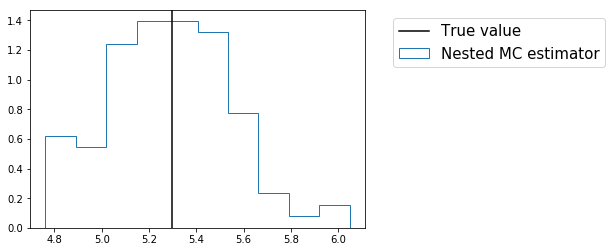

In [9]:
################################################
# Parameters M et N of the Nested MC estimator
M = int(1.e3)
N = M

################################################
# We generate a sample of k i.i.d. values tirages
# of the estimator 
k = 100

sample_nested_estim = np.zeros(k)

from time import time
time0 = time()

##########################################
## To Do: generate the samples of I_{M,N}
for i in range(k):
    sample_nested_estim[i] = NestedEstimator(t_1, t_2, K, S_0, sigma, M, N)

time1 = time()

###########################################
# To Do: estimate the RMSE from the sample
# of k values of I_{M,N} generated above

MSE = np.mean( (sample_nested_estim - benchmark_value)**2 )

RMSE = np.sqrt(MSE)

#######################################
# Some printing of the results
print("**Nested estimator \n")
print("M = %1.0f outer samples and N = %1.0f inner samples \n" %(M,N) )
print("k = %1.0f samples of the Nested estimator \n" %k )
print("Estimateur I_{M,N} (1 sample) = %1.3f \n" %sample_nested_estim[0] )
print("RMSE = %1.3f \n" %RMSE )
print("Time = %1.2f \n" %(time1-time0) )

#####################################
# To Do: histogram of the estimator

plt.hist( sample_nested_estim , density=True, histtype='step', bins=int(np.sqrt(k)), label="Nested MC estimator")

plt.axvline(benchmark_value, linewidth=1.5, color='k', label="True value")

plt.legend(loc=9, fontsize=15, bbox_to_anchor=(1.4, 1.0), ncol=1)
plt.show()

#### $\blacktriangleright$ Remark (pricing measure and historical measure)

The estimator above can also be applied to the evaluation of the (proper) expected loss

$$
\mathbb E^{\mathbb P^{\mathrm{hist}}} \Bigl[\Bigl(P(t_1, S_{t_1}) - P(t_0, S_0) \Bigr)^+ \Bigr]
$$

where $\mathbb P^{\mathrm{hist}}$ is the physical measure of the market, under which we assume that the underlying spot price follows the dynamics

$$
S_{t_i} = S_0 \, e^{\sigma \, W_{t_i} \, + \, (\mu - \frac 12 \sigma^2 ) t_i},
\hspace{30mm} (1)
$$

where $\mu$ is a drift parameter.

Note that we still have a nested expectation problem, the difference being that now the outer expectation $\mathbb E^{\mathbb P^{\mathrm{hist}}}$ and the inner expectation $P(t_1, S_{t_1}) = \mathbb E \bigl[ (K - S_{t_2})^+ \big| S_{t_1} \bigr]$ are computed according to different probability measures.

$\blacktriangleright$ __Question__: How would you modify the estimator and the code above so to take the historical model $(1)$ into account? 

## Exercice 2. Dynamic programming with empirical regression: the example of the Bermudan Put

#### $\blacktriangleright$ Setting

In the framework of the discrete-time Black-Scholes model of the previous exercise

$$
S_i = S_0 \, e^{\sigma \, W_i - \frac 12 \sigma^2 t_i},
\qquad t_0 < t_1 < \dots < t_n
$$

we wish to evaluate the price of a Bermudan put option of maturity $T=t_n$, which 

+ can be exerced by its owner at any date $t_i$ previous to $T$


+ if exercised at $t_i$, generates the gain $(K - S_i)^+$.

This pricing problem for such an option is an example within the more general family of _optimal stopping problems_ (the owner looks for an optimal exercise time).

#### $\blacktriangleright$ The recursive dynamic programming equation

The theory of optimal stopping allow to represent the price $Y_i$ of the Bermudan option at any date $t_i$ in terms of the corresponding _dynamical programming equation_: starting from the final value $Y_n = (K - S_n)^+$, we have to evaluate recursively

$$
\left\{
\begin{aligned}
&Y_n = (K - S_n)^+
\\
&Y_i = \max \left( (K - S_i)^+, \mathbb E \bigl[Y_{i+1} \big| S_i \bigr] \right)
\qquad i = n-1, \dots, 0.
\end{aligned}
\right.
$$

The equation above

+ Requires to evaluate the conditional expectation $\mathbb E[Y_{i+1} | S_i]$ ($Y_{i+1}$ being known from the evaluation already performed at date $t_{i+1}$).


+ is arguably still simpler to implement than the representation of the option price as
$$
Y_0 = \sup_{\tau \in \mathcal{T}_n } {\mathbb E}\bigl[ (K - S_\tau)^+ \bigr],
$$
where $\mathcal{T}_n$ is the set of all possible (random) stopping times with values in $\{0,t_1,\dots, t_n\}$.


Note that the dynamic programming for optimal stopping is a specific example of more general recursive equations of the form

$$
Y_i =  f\left( t_i, S_i, \mathbb E \bigl[Y_{i+1} | S_i \bigr] \right)
$$

where $f$ is a given function, that appear when simulating _backward_ stochastic differential equations.

#### $\blacktriangleright$ The pricing problem in a simple two-period framework

When $n=2$, the Bermudan put price is given by

$$
\begin{aligned}
Y_0 &= \max \left\{ (K-S_0)^+, \mathbb E \left[ Y_1 \right] \right\}
\\
&= \max \left\{ (K-S_0)^+, \mathbb E \left[ \max \Bigl( (K - S_1)^+, \mathbb E \left[ (K - S_2)^+ |S_1 \right] \Bigr) \right] \right\}
\end{aligned}
$$

The problem is analogous to one considered in the previous exercise: we are in front of a nested expectation of the form $\mathbb E \bigl[ g \bigl(X, \mathbb E[f(X,Y)|X] \bigr)  \bigr]$ (now for a different expression of the outer function $g$). 

### 1. Benchmark price

Exactly as in the previous exercise, in the present two-period setting we have a semi-explicit formula for the Bermudan option price, which we can use a reference value for other estimators.

Here again, we exploit the explicit knowledge of the function (the European put price)

$$
\mathbb E \left[ (K - S_2)^+ |S_1 \right] = P(t_1, S_1)
$$

which allows to define the estimator

$$
Y_0^{M} = \max \Bigl\{
(K-x_0)^+, \frac 1M \sum_{m = 1}^M \max\left( (K - S_{1}^m)^+, P(t_1, S_1^m) \right) \Bigr\}
$$

based on a sample $(S_{1}^m)_{m = 1, \dots, M}$ of i.i.d. values of $S_1$.

In the cells below:

+ For future use of empirical regression and for visualisation purposes, we rewrite the put price as a function of the Brownian motion $W_1$ at time $t_1$ rather than the spot price $S_1$ (the one being a function of the other): we define
$$
v_1(W_1) := P(t_1, S_1) = P \Bigl( t_1, S_0 \, e^{\sigma \, W_1 \, - \, \frac 12 \sigma^2 t_1} \Bigr)
$$
so that the estimator above reads
$$
Y_0^{M} = \max \Bigl\{
(K-x_0)^+, \frac 1M \sum_{m = 1}^M \max\left( (K - S_{1}^m)^+, v_1(W_1^m) \right) \Bigr\}
$$

In [10]:
## Problem parameters
K = 1.2
S_0 = 1.
sigma = 0.2
 
t_2 = 2.
t_1 = t_2 / 2.
 
M = int(5e3)

In [11]:
def putBlackScholes(S_0, t_1, t_2, K, W_1, sigma):
    """
    Black Scholes price at t_1 of a put option with maturity t_2,
    as a function of the underlying Brownian motion
    at time t_1.
     
    W_1: numpy array
    """
    S_1 = S_0 * np.exp(sigma*W_1 - 0.5*sigma*sigma*t_1)
    
    price = putPrice(t=t_1, S=S_1, T=t_2, K=K, sigma=sigma)
        
    return price

###################################################
# The function below is useful to obtain the values
# of S at time t once the values of W_t are given.
#
# GBM stands for "Geometric Brownian Motion"
###################################################
def GBM(S_0, t, sigma, W):
    return S_0 * np.exp(-0.5*sigma*sigma*t + sigma * W)
 
time0 = time()
 
#################################################
# To Do: generate a sample of M values of W_1
# and the corresponding sample of values of S_1

W_1 = np.sqrt(t_1) * np.random.randn(M) 
S_1 = GBM(S_0, t_1, sigma, W_1)  

################################################

time0_1 = time()
 
timeSimulations = time0_1 - time0
 
###################################################
### 1. Prix Benchmark
###################################################
 
time1 = time()
 
v_1 = putBlackScholes(S_0, t_1, t_2, K, W_1, sigma)
 
################################################
## TO DO: evalute the benchmark price Y_0^M

def pos_part(x):
    return np.maximum(x, 0)

benchmark_price = np.mean(  np.maximum( pos_part(K -  S_1), v_1) ) 

benchmark_price = np.maximum(benchmark_price, 0)

var_TCL = np.var(np.maximum( pos_part(K -  S_1), v_1))  # update here
################################################
 
radiusIC = 1.96 * np.sqrt(var_TCL/M)
 
time2 = time()
 
print("Benchmark price= %1.4f +/- %1.4f \n" %(benchmark_price, radiusIC) )
print("Erreur relative (TCL) = %1.3f \n" %(radiusIC / benchmark_price) )
print("Time: %1.4f \n" %(time2 - time1 + timeSimulations) )

Benchmark price= 0.2455 +/- 0.0039 

Erreur relative (TCL) = 0.016 

Time: 0.0030 



### 2. Price by empirical regression

$\blacktriangleright$ In this question, we proceed as if we did not know explicitly the conditional expectation $\mathbb E \left[ (K - S_2)^+ \big|S_1 \right]$ (which is the realistic case in practice, for more general stochastic models and more complex portfolios).

$\blacktriangleright$ We therefore have to _approximate_ the conditional expectation, which we can do applying __least square linear regression__ to a simulated i.i.d. sample of the couple $(W_1, (K - S_2)^+)$.


$\blacktriangleright$ We will therefore need to simulate a sample $(W_1^m, S_2^m)_{1 \le m \le M}$ of i.i.d. values of the couple $(W_1, S_2)$.

One can note that, in this part, we work with $M$ samples in total - as opposed to the $M \times N$ samples of the Nested Monte-Carlo procedure.

#### Choice of the regression space

+ We are going to build an empirical approximation $\tilde v_1$ of the function
$$
x \mapsto v_1(x) = 
P \left(T_1, e^{\sigma \, x \, - \, \frac12 \sigma^2 T_1 } \right)
$$
on the state space of the Brownian motion $W_1$. 


+ We choose as an approximation space the space generated by the indicator functions of disjoint intervals $I_k$
$$
\varphi_k(x) = 1_{I_k}(x),
\quad
\quad k = 1, \dots, n,
$$
where
$$
I_k = \left[-a + (k-1) \delta, -a + k \delta \right[, \qquad \delta = \frac{2a}n
$$
so that the union of the $I_k$'s is the (large) interval $[-a,a]$.

#### The regression problem for $v(x) = \mathbb E \left[ (K - S_2)^+ \big|W_1 = x \right]$

+ As stated above, we approximate the function $v_1$ using the elements of the vector space
$$
\Phi = \text{Vect}(\varphi_1,\dots, \varphi_n)
= \left\{\sum_{k=1}^n \alpha_k 1_{I_k}(\cdot): \alpha_1, \dots, \alpha_n \in \mathbb{R} \right\}.
$$
that is, using piece-wise constant functions of the form $\sum_{k=1}^n \alpha_k 1_{I_k}(\cdot)$.


+ The __least square regression coefficients__ for the function $v(x) = \mathbb E \left[ (K - S_2)^+ |W_1 = x \right]$ are defined by the minimization problem
$$ \label{e:regrEmp}
\begin{aligned}
\alpha^* = \underset{\alpha\in \mathbb{R}^n}{\rm arg\min}
\ \frac 1 M \sum_{m = 1}^M
\left(
\bigl(K - S_2^m \bigr)^+ - \sum_{k=1}^n \alpha_k 1_{I_k}(W_1^m)
\right)^2.
\end{aligned}
$$
Once the $\alpha^*_k$ are known, the regression function (that is, the empirical approximation of $v_1(\cdot)$) is given by
$$
\tilde v_1(\cdot) = \sum_{k=1}^{n} \alpha_k^* \ 1_{I_k}(\cdot)
$$


+ Finally, once the regression function $\tilde v_1$ has been evaluated, the new estimator of the Bermudan put is
$$
\tilde{Y}_0^{M} = 
\max \Bigl\{
(K - x_0)^+, \frac 1M \sum_{m=1}^M \max \left( (K - S_{1}^m)^+, \tilde{v}_1(W_1^m) \right)
\Bigr\}.
$$

$\blacktriangleright$ __Question__: do we have an explicit expression for the regression coefficients $\alpha^*_k$? 

__Answer__: in the case of disjoint intervals $I_k$, the expression of the optimal regression coefficients $\alpha^*$ is relatively simple: denoting

$$
N_k = \#\{m: \ W_1^m \in I_k \}
$$

the number of samples  $W_1^m$ contained in the cell $I_k$, we have

$$
\alpha_k^* = \left\{
\begin{array}{ll}
\frac 1 {N_k}
\sum_{m = 1}^M
\left(K - S_2^m \right)^+ 1_{\{W_1^m \in I_k\}}
& \quad \mbox{if } N_k \neq 0
\\
0 & \quad \mbox{otherwise}
\end{array}
\right.
$$

The default choice $\alpha_k^*=0$ corresponds to the vector of coefficients $\alpha^*$ of minimal norm in $\mathbb R^n$.

In the cell below, evaluate

+ the coefficients $\alpha^*_k$ in the Python function `EmpiricalRegression`
+ the Bermudan price estimator $\tilde Y_0^{M}$.

Price by empirical regression = 0.2483
Time: 0.0020 



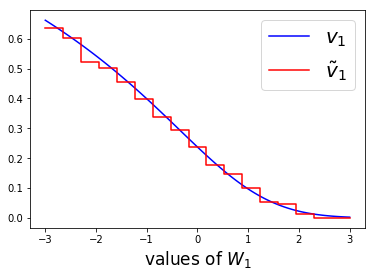

In [12]:
##################################################
### 2. Bermudan put price by empirical regression 
##################################################

#################################################
# First of all: 
# + Generate a sample of M values of W_2
#   and the corresponding values of S_1
# + Taking into account that the values of W_1
#   have already been simulated above
#################################################
W_2 = W_1 + np.sqrt(t_2 - t_1) * np.random.randn(M) 
S_2 = GBM(S_0, t_2, sigma, W_2) 
################################################

###############################
## We generate the cells I_k
###############################
a = 3. * np.sqrt(t_1)
 
#################################################
# n = the dimension of the approximation space
# 
# It can be shown that n = M*{1/3} is a pertinent
# choice for a problem in dimension d = 1, as here
#################################################
n = int(M**(1./3))
 
partition_points = np.linspace(-a, a, n+1)
 
####################################################
## TO DO: evaluate
## + The regression coefficients alpha
## + The vector v_1_tilde(W1) of size M 
##   inside the array v_1_tilde
####################################################
def EmpiricalRegression(W_1, W_2, partition_points, t_2, K, S_0, sigma):
    step = partition_points[1] - partition_points[0]
    
    alpha = np.zeros(partition_points.size - 1)
    
    v_1_tilde = np.zeros(M)
     
    for k in range(n):
        
        leftPoint = partition_points[k]
        
        insideCell = np.logical_and( leftPoint <= W_1, W_1 < leftPoint+step )         
        
        GBM_t_2 = GBM(S_0, t_2, sigma, W_2[insideCell])
        
        #############################################
        ## TO DO: evaluate the coefficients alpha[k]
        #############################################
        numberInsideCell = np.sum(insideCell)
        
        if numberInsideCell != 0:
            alpha[k] = np.sum( pos_part(K - GBM_t_2) ) / numberInsideCell
        
        #############################################
        ## TO DO: evaluate the empirical approximation
        ## v_1_tilde(W1) inside the array v_1_tilde
        #############################################
        v_1_tilde[insideCell] = alpha[k] 
     
    return alpha, v_1_tilde
 
time3 = time()
 
alpha, v_1_tilde = EmpiricalRegression(W_1, W_2, partition_points, t_2, K, S_0, sigma) 

################################################
# TO DO: evaluate the new estimator Y_tilde_0^M 
# of the Bermudan put price

price_EmpRegr = np.mean(  np.maximum( pos_part(K -  S_1), v_1_tilde) ) 

price_EmpRegr = np.maximum(price_EmpRegr, 0)

################################################
 
time4 = time()
 
print("Price by empirical regression = %1.4f" %price_EmpRegr)
print("Time: %1.4f \n" %(time4 - time3 + timeSimulations))
 
#######################################################
## We can also plot the true function v_1 and its
## empirical approximation v_1_tilde for comparison
#######################################################
x = np.linspace(-a, a, 100)
 
v_1_exact = putBlackScholes(S_0, t_1, t_2, K, x, sigma)
 
plt.plot(x, v_1_exact, color="b", label="$v_1$")
 
plt.step(partition_points, np.append(alpha, alpha[-1]), where="post", color="r", label=r"$\tilde{v}_1$")
 
plt.xlabel("values of $W_1$", fontsize=17)
plt.legend(loc="best", fontsize=20)

### 2. Nested Monte-Carlo price

In the spirit of Exercise 1, we can also propose a Nested Monte-Carlo estimator that does not require the knowledge of the inner conditional expectation $\mathbb E \left[ (K - S_2)^+ \big|W_1 = x \right]$.

This third estimator is

$$
\hat{Y}_0^{M} = \max \Bigl\{ (K-x_0)^+,
\frac 1M \sum_{m = 1}^M \max\left( (K - S_{1}^m)^+, \hat{v}_{1}^m \right)
\Bigr\}
$$

where now, for every $m$, the estimate $\hat{v}_{1}^m$ of $v_1(W_m^1)$ is obtained from a sample of $N$ i.i.d. values $(\Delta W^{m, n})_{1 \le n \le N}$ of the Brownian increment between $t_1$ and $t_2$:

$$
\hat{v}_{1}^m = \frac1{N} \sum_{n = 1}^N \Bigl(K - S_0 \exp
\Bigl(-\frac12 \sigma^2 T_2 \ + \sigma (W_1^m + \Delta W^{m, n} \Bigr)
\Bigr)^+.
$$

$\blacktriangleright$ Simulate the Nested estimator $\hat{Y}_0^{M}$ in the cell below, and compare with the previous methods.

In [13]:
##################################
## 3. Nested Monte-Carlo price
##################################
 
###################################################
# We now have to generate N samples of S_2 for every
# point in the sample of M values of W_1.
#
# We will therefore need to repeat N gaussian iid samples
# of the Browian increment W_2 - W_1
# for every value of W_1 previously simulated
###################################################
N = int(np.sqrt(M))

# This variable will contain the sum over m in {1,...,M}
sum_1 = 0.
 
time7 = time()
 
for m in range(M):
    w1 = W_1[m]
    s1 = GBM(S_0=S_0, t=t_1, sigma=sigma, W=w1)
     
    ###################################################
    ## To Do: 
    ## - Simulation of N Brownian increments
    ## - Generation of W_2, therefore of S_2, conditionally to W1 = w1
    ## - update the sum over m with the current contribution
    ###################################################
    G = np.random.randn(N)
    
    W2 = w1 + np.sqrt(t_2 - t_1) * G
    
    S2 = GBM(S_0=S_0, t=t_2, sigma=sigma, W=W2)
    
    v_1_hat = np.mean( pos_part(K - S2) )
    
    sum_1 += np.maximum( v_1_hat, pos_part(K - s1) )
    ###################################################

Y_0_hat = np.maximum( np.maximum(K-S_0, 0.), sum_1 / M )
    
time8 = time()
 
print("Nested MC price = %1.4f" %Y_0_hat)
print("Time: %1.4f" %(time8 - time7), "\n")

Nested MC price = 0.2479
Time: 0.1940 

